In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
%matplotlib inline

In [3]:
df_train = pd.read_csv("../data/train_new.csv")
print('Number of train records: {}'.format(len(df_train)))
df_train.head()

Number of train records: 60000


,rent_approval_date,town_0,town_1,town_2,town_3,town_4,block,street_name,flat_model,floor_area_sqm,...,flat_type_3-room,flat_type_4-room,flat_type_executive,flat_type_5-room,flat_type_2-room,central region,east region,north region,north-east region,west region
0,0.038835,0,0,0,0,1,2408.825929,2328.509655,2,67.0,...,1,0,0,0,0,0,0,0,0,1
1,0.504854,0,0,0,1,0,2349.797336,2402.958147,2,92.0,...,0,1,0,0,0,0,1,0,0,0
2,0.529126,0,0,0,1,1,2412.848474,2420.893097,7,67.0,...,1,0,0,0,0,1,0,0,0,0
3,0.033981,0,0,1,0,0,2380.197160,2631.276086,9,149.0,...,0,0,1,0,0,0,1,0,0,0
4,0.533981,0,0,1,0,1,2484.314502,2284.955112,7,68.0,...,1,0,0,0,0,1,0,0,0,0


In [4]:
df_test = pd.read_csv("../data/test_new.csv")
print('Number of test records: {}'.format(len(df_test)))
df_test.head()

Number of test records: 30000


,rent_approval_date,town_0,town_1,town_2,town_3,town_4,block,street_name,flat_model,floor_area_sqm,...,flat_type_3-room,flat_type_4-room,flat_type_executive,flat_type_5-room,flat_type_2-room,central region,east region,north region,north-east region,west region
0,0.970874,1,0,1,1,1,2624.520690,2379.499974,7,121.0,...,0,0,0,1,0,0,0,0,1,0
1,0.524272,0,1,1,1,0,2524.058532,2615.882473,6,100.0,...,0,1,0,0,0,0,0,1,0,0
2,1.000000,0,1,1,0,0,2696.577167,2567.505982,2,91.0,...,0,1,0,0,0,0,0,0,0,1
3,0.033981,0,0,0,0,1,2515.834726,2821.948226,6,74.0,...,1,0,0,0,0,0,0,0,0,1
4,0.495146,0,0,0,0,1,2609.989756,2282.274343,7,121.0,...,0,0,0,1,0,0,0,0,0,1


In [5]:
# print(df_train.columns)
cols = ['rent_approval_date', 
        'town_0', 'town_1', 'town_2', 'town_3', 'town_4', #for binary encoding
#         'town', #for target encoding (higher MAE? awaiting leaderboard verification)
       'flat_model', 'floor_area_sqm', 'lease_commence_date',
       'avg_stock_price', 'num_shopping_malls', 'min_distance',
       'avg_coe_price', 'num_primary_schools', 'min_distance_planned',
       'flat_type_3-room', 'flat_type_4-room', 'flat_type_executive', 'flat_type_5-room', 'flat_type_2-room',
       'central region', 'east region', 'north region', 'north-east region', 'west region',
       'subzone'] #removed: 'latitude', 'longitude', 'furnished', 'elevation', 'planning_area', 'street_name', 'block'
"""
TODO:
1. submit output with subzone
2. submit output with lat/lon
3. submit output with town target encoding
"""

y_train = df_train['monthly_rent'].values
X_train = df_train[cols].values


X_test = df_test[cols].values

# Gradient Boosting with SKLearn

### Use HistGradientBoostingRegressor since it's much faster for large dataset

MAE: -366.935 (4.738)
30000
[3280, 2668, 3422, 1932, 2682]


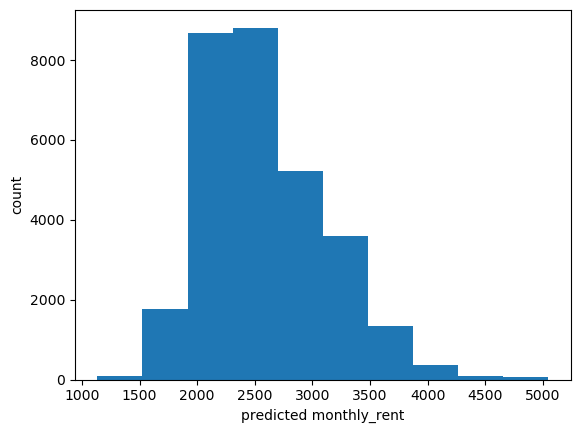

CPU times: user 2.08 s, sys: 133 ms, total: 2.21 s
Wall time: 4.6 s


In [6]:
%%time
categorical_features = []
i_list = []
score = []

model = HistGradientBoostingRegressor( loss='gamma',
                                               learning_rate=0.14,
                                               max_depth=None,
                                               max_bins=255,
                                               categorical_features=categorical_features,
                                               random_state=237,
                                             l2_regularization=2.4) 

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

model = HistGradientBoostingRegressor( loss='gamma',
                                       learning_rate=0.14,
                                       max_depth=None,
                                       max_bins=255,
                                       categorical_features=categorical_features,
                                       random_state=237,
                                     l2_regularization=2.4)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = [int(x) for x in y_pred] 
print(len(y_pred))
print(y_pred[:5])

plt.hist(y_pred)
plt.xlabel('predicted monthly_rent')
plt.ylabel('count')
plt.show()

# Gradient Boosting with XGBoost

In [7]:
# %%time
# model = XGBRegressor(objective='reg:squarederror')

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# model = XGBRegressor(objective='reg:squarederror')
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

# Gradient Boosting with CatBoost

In [8]:
# %%time
# model = CatBoostRegressor(verbose=0, n_estimators=100)

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# model = CatBoostRegressor(verbose=0, n_estimators=100)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

# Gradient Boosting with LightGBM

In [9]:
# why 30mins?
# %%time
# model = LGBMRegressor()

# cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# model = LGBMRegressor()
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)
# y_pred = [int(x) for x in y_pred] 
# print(len(y_pred))
# print(y_pred[:5])

# plt.hist(y_pred)
# plt.xlabel('predicted monthly_rent')
# plt.ylabel('count')
# plt.show()

In [10]:
df = pd.DataFrame(y_pred, columns =['Predicted'], dtype = float) 
df.head()

,Predicted
0,3280.0
1,2668.0
2,3422.0
3,1932.0
4,2682.0


In [11]:
df.to_csv("../data/gb_output.csv", index_label='Id')